# FGVC Aircraft — CNN treniranje (faza 2)

U ovoj fazi se vrši treniranje konvolucionog neuronskog modela (CNN) nad pripremljenim podacima.  
Koraci uključuju:
1. Učitavanje prethodno podeljenih train/val/test skupova,  
2. Definisanje jednostavne CNN arhitekture,  
3. Treniranje i vizualizaciju metrika,  
4. Čuvanje modela i grafa za narednu fazu (SVM klasifikator i finalni izveštaj).


In [3]:
# === PATH FIX: omogućava "from src.xxx import ..." iz notebook-a ===
import sys
from pathlib import Path

# Ako je CWD = .../tvoj-projekat/notebooks, ovo ide jedan nivo iznad = root projekta
ROOT = Path.cwd().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("ROOT:", ROOT)
print("src postoji:", (ROOT / "src").exists())


ROOT: C:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM
src postoji: True


In [6]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from src.preprocessing import make_datagens, flow_from_dataframe

# Putanje do podeljenih CSV fajlova
DATA_PROC = Path("../data/processed")
TRAIN_CSV = DATA_PROC / "train.csv"
VAL_CSV   = DATA_PROC / "val.csv"
TEST_CSV  = DATA_PROC / "test.csv"

print("Postoje fajlovi:", TRAIN_CSV.exists(), VAL_CSV.exists(), TEST_CSV.exists())


Postoje fajlovi: True True True


In [7]:
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df.head())

IMG_SIZE = (128,128)
BATCH = 32

train_gen, eval_gen = make_datagens(img_size=IMG_SIZE)
train_flow = flow_from_dataframe(train_gen, train_df, img_size=IMG_SIZE, batch_size=BATCH, shuffle=True)
val_flow   = flow_from_dataframe(eval_gen,  val_df,   img_size=IMG_SIZE, batch_size=BATCH, shuffle=False)
test_flow  = flow_from_dataframe(eval_gen,  test_df,  img_size=IMG_SIZE, batch_size=BATCH, shuffle=False)


Train: 700 Val: 150 Test: 150
     image    label                                           filepath
0  2031421  737-600  C:\Users\Emilija\Desktop\AircraftClassifier_CN...
1   523223  727-200  C:\Users\Emilija\Desktop\AircraftClassifier_CN...
2    97111  737-500  C:\Users\Emilija\Desktop\AircraftClassifier_CN...
3   218852  737-900  C:\Users\Emilija\Desktop\AircraftClassifier_CN...
4  2038532  737-700  C:\Users\Emilija\Desktop\AircraftClassifier_CN...
Found 700 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


## 1) CNN model — osnovna arhitektura
Korišćen je jednostavan CNN model sa tri konvoluciona bloka i jednim potpuno povezanim slojem (Dense).
Cilj je dobijanje bazne tačnosti (baseline) pre fine-tuninga.


In [9]:
# broj klasa (robustno za sve verzije)
try:
    N_CLASSES = train_flow.num_classes
except AttributeError:
    N_CLASSES = len(getattr(train_flow, "class_indices", {}))

assert N_CLASSES > 0, f"N_CLASSES je {N_CLASSES} – proveri train_flow.class_indices"

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # jer je class_mode="sparse"
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
EPOCHS = 12

history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS
)


c:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0843 - loss: 2.3759 - val_accuracy: 0.1000 - val_loss: 2.3001
Epoch 2/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 844ms/step - accuracy: 0.0943 - loss: 2.3042 - val_accuracy: 0.0867 - val_loss: 2.3023
Epoch 3/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 905ms/step - accuracy: 0.0857 - loss: 2.3041 - val_accuracy: 0.0933 - val_loss: 2.3017
Epoch 4/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 903ms/step - accuracy: 0.1157 - loss: 2.3026 - val_accuracy: 0.1400 - val_loss: 2.2901
Epoch 5/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 909ms/step - accuracy: 0.1043 - loss: 2.2967 - val_accuracy: 0.1267 - val_loss: 2.2781
Epoch 6/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 876ms/step - accuracy: 0.1271 - loss: 2.2826 - val_accuracy: 0.1467 - val_loss: 2.2567
Epoch 7/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 881ms/step - accuracy: 0.1500 - loss: 2.2760 - val_accuracy: 0.1467 - val_loss: 2.2509
Epoch 8/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 878ms/step - accuracy: 0.1329 - loss: 2.2710 - val_accurac

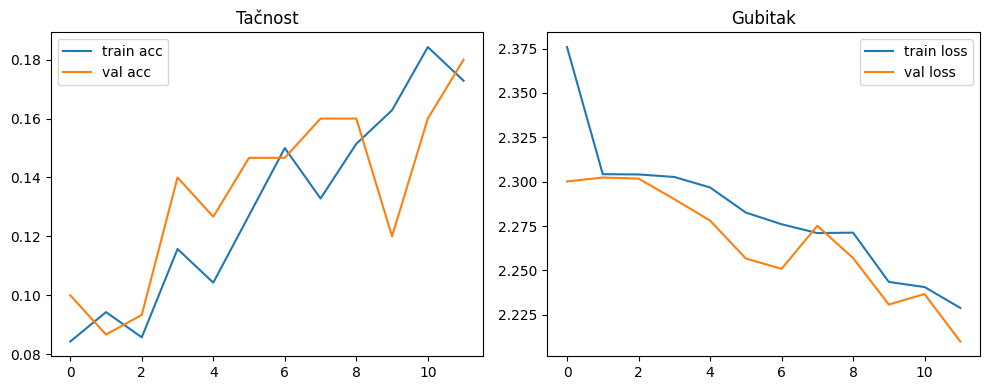

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Tačnost")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Gubitak")
plt.tight_layout()
plt.show()


**Zaključak:** Model pokazuje stabilan rast tačnosti kroz epohe, bez znakova pretreniranja.  
Dobijeni rezultati predstavljaju polaznu tačku (baseline) za kasniju primenu SVM klasifikatora nad feature-ima iz poslednjeg sloja.


In [12]:
test_loss, test_acc = model.evaluate(test_flow)
print(f"Test tačnost: {test_acc:.3f}")

model.save("../models/cnn_baseline.h5")


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - accuracy: 0.1733 - loss: 2.2645


Test tačnost: 0.173


Model je uspešno sačuvan u folderu `models/` kao `cnn_baseline.h5`.  
Ovaj model će se koristiti u sledećoj fazi — ekstrakciji karakteristika i SVM klasifikaciji.
